In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# 设置随机种子，保证实验结果可复现
torch.manual_seed(42)

# 加载数据
data_path = 'stock_dataset_2.csv'
data = pd.read_csv(data_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 使用的特征和目标
features = ['open', 'high', 'low', 'close', 'volume']
target = 'label'
data_full = data[features + [target]]

# 归一化特征和目标值
scaler = MinMaxScaler(feature_range=(0, 1))
data_full[features] = scaler.fit_transform(data_full[features])
data_full['label'] = scaler.fit_transform(data_full[['label']])

# 准备输入输出对
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]
        X.append(a)
        Y.append(dataset[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 7
scaled_data = data_full.values
X, Y = create_dataset(scaled_data, look_back)

# 转换为 PyTorch 的 Tensor
X_tensor = torch.tensor(X).float()
Y_tensor = torch.tensor(Y).float()

# 划分训练测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
Y_train, Y_test = Y_tensor[:train_size], Y_tensor[train_size:]

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc1(out[:, -1, :])  # 取最后一个时间步的输出
        out = self.fc2(out)
        
        return out.squeeze(1)

# 初始化模型
input_size = len(features)
hidden_size = 50
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 转移到 GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 测试模型
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# 计算 RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train.cpu().numpy(), train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test.cpu().numpy(), test_predict))

print(f'Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}')

/tmp/ipykernel_408/817201548.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full[features] = scaler.fit_transform(data_full[features])
/tmp/ipykernel_408/817201548.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full['label'] = scaler.fit_transform(data_full[['label']])


Epoch [1/200], Loss: 0.0519
Epoch [6/200], Loss: 0.0293
Epoch [11/200], Loss: 0.0280
Epoch [16/200], Loss: 0.0249
Epoch [21/200], Loss: 0.0202
Epoch [26/200], Loss: 0.0145
Epoch [31/200], Loss: 0.0057
Epoch [36/200], Loss: 0.0013
Epoch [41/200], Loss: 0.0032
Epoch [46/200], Loss: 0.0011
Epoch [51/200], Loss: 0.0009
Epoch [56/200], Loss: 0.0010
Epoch [61/200], Loss: 0.0005
Epoch [66/200], Loss: 0.0005
Epoch [71/200], Loss: 0.0005
Epoch [76/200], Loss: 0.0003
Epoch [81/200], Loss: 0.0003
Epoch [86/200], Loss: 0.0003
Epoch [91/200], Loss: 0.0003
Epoch [96/200], Loss: 0.0003
Epoch [101/200], Loss: 0.0002
Epoch [106/200], Loss: 0.0002
Epoch [111/200], Loss: 0.0002
Epoch [116/200], Loss: 0.0002
Epoch [121/200], Loss: 0.0002
Epoch [126/200], Loss: 0.0002
Epoch [131/200], Loss: 0.0002
Epoch [136/200], Loss: 0.0002
Epoch [141/200], Loss: 0.0002
Epoch [146/200], Loss: 0.0002
Epoch [151/200], Loss: 0.0002
Epoch [156/200], Loss: 0.0002
Epoch [161/200], Loss: 0.0002
Epoch [166/200], Loss: 0.0002
Ep

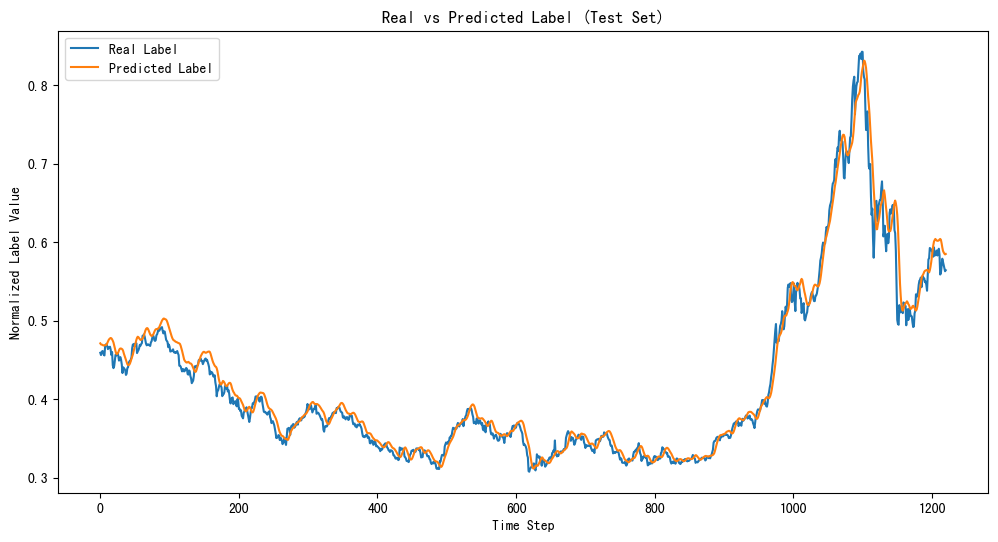

In [9]:
import matplotlib.pyplot as plt

# 生成测试集真实值和预测值的折线图
plt.figure(figsize=(12, 6))
plt.plot(Y_test.cpu().numpy(), label='Real Label')
plt.plot(test_predict, label='Predicted Label')
plt.xlabel('Time Step')
plt.ylabel('Normalized Label Value')
plt.title('Real vs Predicted Label (Test Set)')
plt.legend()
plt.show()
